<h1>MLTS Exercise 02 - Bayesian Linear Regression</h1>

### Task

* *Adapted from a code by Zoubin Ghahramani*

* Implement the log marginal likelihood for training a Bayesian linear regression model (`linregFitBayes`)

* Implement the prediction for Bayesian linear regression (`linregPredictBayes`)

* Learn the parameters of a linear regression for some noisy measurements of a function by maximizing log marginal likelihood w.r.t. to the parameters

* Use the trained model to make predictions on previously unseen test data


### Basic variables

* parameters: $\alpha, \beta$

* weights: $w$

* Datapoints: $N$

### Helpfull intermediate variables

* $X^* = X^TX$

* $X_y = X^Ty$

### Needed Variables

* $A = αI + βX^*$

* $U = cholesky(A)^T$

* $U_i = U^{-1}$

* $A^{-1 }= U_iU_i^T$

* $m_N = β\ A^{-1}\ X_y$

* $E(m_N) = \frac{β}{2}\parallel y - X\ m_N \parallel^2 + \frac{α}{2}\ m_N^T\ m_N$

#### Log marginal likelihood

* $ln \textrm{ } p(y|X) = \frac{M}{2}\ ln\ α + \frac{N}{2}\ ln\ β − E(m_N) − \frac{1}{2}\ ln\ |A| − \frac{N}{2}\ ln(2π)$

* $α = \cfrac{\gamma}{m_N^Tm_N}$

* $\gamma = M - α tr(A^{-1})$

* $β = \cfrac{N - \gamma}{\sum^N_{n=1}(y_n - m^T_N x_n)^2}$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
def polyBasis(x, deg):
    #Takes a vector and returns a polynomial basis matrix up to degree deg
    return(np.column_stack([x**deg for deg in range(deg+1)]))

<h3>Task: Implement the log marginal likelihood for training a Bayesian linear regression model</h3>

In [3]:
def linregFitBayes(X, y, maxIter):
    #This learn a Bayes regression model by optimizing log marginal likelihood. 
    
    #we can start with some initial values for alpha and beta and then change them iteratively based on data
    alpha = 0.01 
    beta = 1 

    log_ml_old = - float('inf') #initialize log marginal likelihood
    Lhist = np.empty((maxIter, 1))

    #implement the log marginal likelihood logp(Y|X) and for a fixed number of iteration optimize it 
    #at each loop iteration compare new (L) and old (L_old) log marginal likelihood
    #if abs(L - L_old) < 1e-2 stop the optimization

    #Initialize some variables
    N, M = X.shape

    XX = np.dot(np.transpose(X), X)
    Xy = np.dot(np.transpose(X), y)

    for i in range(maxIter):
        
        A = alpha * np.identity(M) + beta * XX
        U = np.transpose(np.linalg.cholesky(A))
        U_inv = np.linalg.inv(U)
        A_inv = np.dot(U_inv, np.transpose(U_inv))

        m_N = beta * np.dot(A_inv, Xy)

        t1 = sum((y - np.dot(X, m_N)) * (y - np.dot(X, m_N)))
        t2 = np.dot(np.transpose(m_N), m_N)

        E_mn = beta * t1 - alpha * t2

        # https://xcorr.net/2008/06/11/log-determinant-of-positive-definite-matrices-in-matlab/
        log_det = 2 * sum(np.log(np.diag(U)))
        log_ml = float(M) * np.log(alpha) \
                 + float(N) * np.log(beta) \
                 - E_mn \
                 - log_det \
                 - float(N) * np.log(2 * np.pi)
        log_ml = log_ml / 2.

        gamma = M - alpha * np.trace(A_inv)
        alpha = gamma / t2
        beta = (N - gamma) / t1

        Lhist[i] = log_ml
        if abs(log_ml - log_ml_old) < 1e-2:
            break
        else:
            log_ml_old = log_ml
        
    model = {'m_N': m_N, 'A_inv': A_inv, 'beta': beta, 'alpha': alpha, 'gamma': gamma}

    return model, log_ml_old, Lhist

<h3>Task: Implement the prediction for Bayesian linear regression </h3>

In [4]:
def linregPredictBayes(model, X):
    #This accepts a model of the form produced by linregFitBayes 
    #and an array of X to form posterior predictions p(y∗|x∗,y,X)
    # X.shape = 140x3, m_N.shape = 3
    yhat = np.dot(X, model["m_N"])
    sigma2hat = (1. / model["beta"]) + np.diag(np.dot(np.dot(X, model["A_inv"]), np.transpose(X)))

    return yhat, sigma2hat

<h3>Bayesian model selection demo for polynomial regression</h3>

* **Task:** Learn model parameters based on training data using marginal likelihood
* **Task:** Make predictions on previously unseen test data

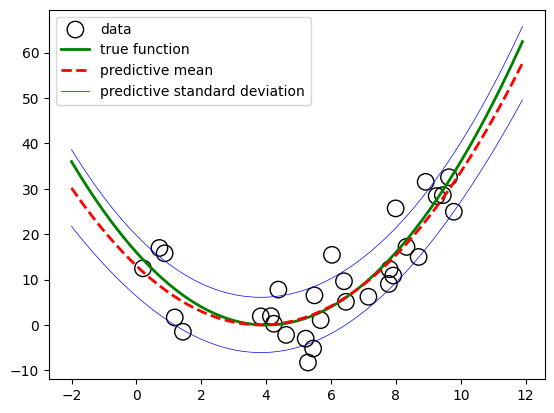

In [5]:
# generate data and plots here
# Change the number of the random seed to get different data points
np.random.seed(0) # to generate the same random data in diffrenet runs

# --- Setup Dataset ---
deg = 2 #degree of polynomial
n = 30 #number of data points
# training x1d and test data plotvals1d
x1d = np.random.uniform(0, 10, n) #input points
e = np.random.normal(0, 1, n) #noise
ytrain = (x1d - 4.0)**2 + 5.0*e #observed y
plotvals1d = np.arange(-2.0, 12, .1) #grid for plotting/testing
trueOutput = (plotvals1d - 4.0) ** 2 #true function

# --- Learn the model parameters based on the training data using marginal likelihood ---
X = polyBasis(x1d, deg) #Polynomial basis
[mod, logev, hist] = linregFitBayes(X, ytrain, maxIter=20) #Fit the model

# --- Make predictions on previously unseen data (test data) ---
Xtest = polyBasis(plotvals1d, deg) #Grid to test our prediction on
[mu, sig2] = linregPredictBayes(mod, Xtest)
sig2 = np.sqrt(sig2)

# --- Plot results ---
plt.plot()
plt.scatter(x1d, ytrain, s=140, facecolors='none', edgecolors='k', label='data')
lower = mu - sig2
upper = mu + sig2
plt.plot(plotvals1d, trueOutput, 'g', linewidth=2, label='true function')
plt.plot(plotvals1d, mu, 'r--', linewidth=2, label='predictive mean')
plt.plot(plotvals1d, lower, 'b-', linewidth=0.5)
plt.plot(plotvals1d, upper, 'b-', linewidth=0.5, label='predictive standard deviation')
plt.legend()
plt.show()